# Age regression from brain MRI

This notebook is based on a coursework submitted for a course in Machine Learning for Imaging. The coursework provided data and high level guidance on strategies. However, the substantive methods were implemented independently.

Text in <em>italics</em> are taken from the coursework information.

<em>Predicting the age of patient from a brain MRI scan can have diagnostic value for a number of diseases that may cause structural changes and potential damage to the brain. A discrepancy between the predicted age and the real, chronological age of a patient might indicate the presence of disease. This requires an accurate predictor of brain age which may be learned from a set of healthy reference subjects, given their brain MRI data and their actual age.

The objective for the coursework is to implement different supervised learning approaches for age regression from brain MRI. We provided data from a total of 652 healthy subjects, that is split into different development sets and a held-out test set on which you will evaluate your final prediction accuracy.

Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are three dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code. </em>


### Getting started and familiarise ourselves with the data

<em> The following cells are some helper functions to load the data, and provide some overview and visualisation of the statistics over the total population of 652 subjects. The data will be split into different subsets to be used for different parts of the coursework. There is a set of 52 subjects to be used in part A to develop an image segmentation method (47 for training, 5 for validation). We then use 500 subjects for training and cross-validation of age regression approaches in part A, B and C. A remaining set of 100 subjects is used to test the final age prediction accuracy and will be made available towards the end of the coursework. </em>

Please note that the data is not provided in this notebook for ethical reasons

In [ ]:
# data directory
data_dir = 'data/brain_age/'

     |████████████████████████████████| 42.5MB 69kB/s 
--2020-03-02 10:59:17--  https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-data.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 900391705 (859M) [application/zip]
Saving to: ‘brainage-data.zip’

brainage-data.zip   100%[===================>] 858.68M   209MB/s    in 4.3s    

2020-03-02 10:59:21 (200 MB/s) - ‘brainage-data.zip’ saved [900391705/900391705]

Archive:  brainage-data.zip
   creating: data/
   creating: data/brain_age/
   creating: data/brain_age/greymatter/
  inflating: data/brain_age/greymatter/wc1sub-CC110033_T1w.nii.gz  
  inflating: data/brain_age/greymatter/wc1sub-CC110037_T1w.nii.gz  
  inflating: data/brain_age/greymatter/wc1sub-CC110045_T1w.nii.gz  
  inflating: data/brain_age/greymatter/wc1sub-CC110056_T1w.nii.gz  
  inflating: data/brain_age/gre

### Running on DoC lab machines

Let's start by loading the meta data of the entire population, that is the data containing information about the subject IDs, their age, and gender.

In [ ]:
# Read the meta data using pandas
import pandas as pd

meta_data_all = pd.read_csv(data_dir + 'meta/meta_data_all.csv')
meta_data_all.head()  # show the first five data entries

,subject_id,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


Let's have a look at some population statistics.

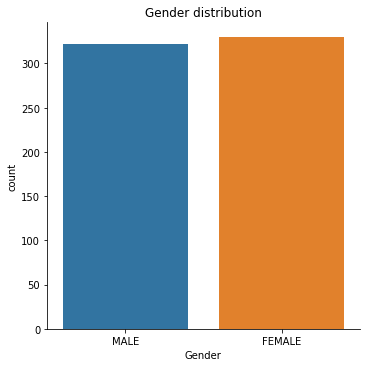

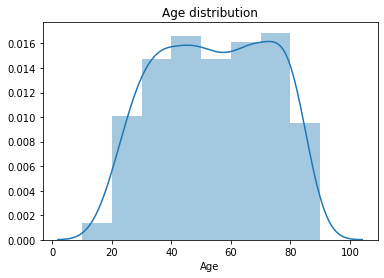

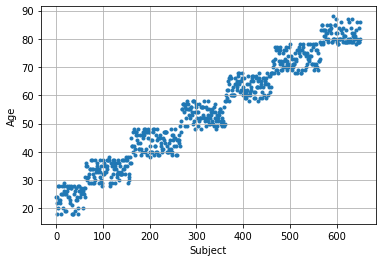

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


meta_data = meta_data_all

sns.catplot(x="gender_text", data=meta_data, kind="count")
plt.title('Gender distribution')
plt.xlabel('Gender')
plt.show()

sns.distplot(meta_data['age'], bins=[10, 20, 30, 40, 50, 60, 70, 80, 90])
plt.title('Age distribution')
plt.xlabel('Age')
plt.show()

plt.scatter(range(len(meta_data['age'])), meta_data['age'], marker='.')
plt.grid()
plt.xlabel('Subject')
plt.ylabel('Age')
plt.show()

### Set up a simple medical image viewer and import SimpleITK

In [ ]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import display

# Calculate parameters low and high from window and level


def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low, high


def display_image(img, x=None, y=None, z=None, window=None, level=None, colormap='gray', crosshair=False):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)

    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth = size[2] * spacing[2]

    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)

    if window is None:
        window = np.max(img_array) - np.min(img_array)

    if level is None:
        level = window / 2 + np.min(img_array)

    low, high = wl_to_lh(window, level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z, :, :], cmap=colormap, clim=(
        low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:, y, :], origin='lower', cmap=colormap, clim=(
        low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:, :, x], origin='lower', cmap=colormap, clim=(
        low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    if crosshair:
        ax1.axhline(y * spacing[1], lw=1)
        ax1.axvline(x * spacing[0], lw=1)
        ax2.axhline(z * spacing[2], lw=1)
        ax2.axvline(x * spacing[0], lw=1)
        ax3.axhline(z * spacing[2], lw=1)
        ax3.axvline(y * spacing[1], lw=1)

    plt.show()


def interactive_view(img):
    size = img.GetSize()
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image, img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0, np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array), np.max(img_array)))

### Imaging data

Let's check out the imaging data that is available for each subject. This cell also shows how to retrieve data given a particular subject ID from the meta data.

Imaging data of subject CC110033 with age 24

MR Image (used in part A)


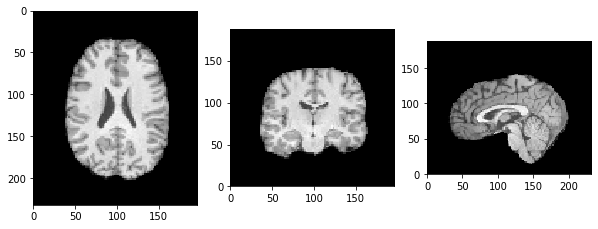

Brain mask (used in part A)


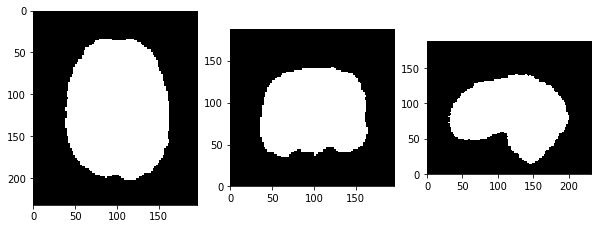

Spatially normalised grey matter maps (used in part B and C)


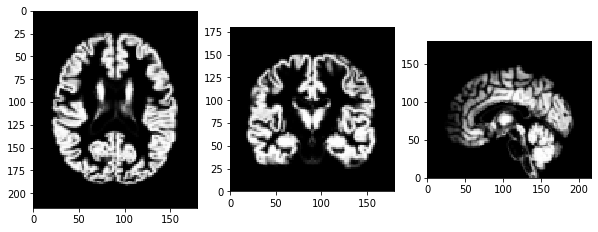

In [ ]:
# Subject with index 0
ID = meta_data['subject_id'][0]
age = meta_data['age'][0]

# Image
image_filename = data_dir + 'images/sub-' + ID + '_T1w_unbiased.nii.gz'
img = sitk.ReadImage(image_filename)

# Mask
mask_filename = data_dir + 'masks/sub-' + ID + '_T1w_brain_mask.nii.gz'
msk = sitk.ReadImage(mask_filename)

# Grey matter map
gm_filename = data_dir + 'greymatter/wc1sub-' + ID + '_T1w.nii.gz'
gm = sitk.ReadImage(gm_filename)

print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image (used in part A)')
display_image(img, window=400, level=200)

print('Brain mask (used in part A)')
display_image(msk)

print('Spatially normalised grey matter maps (used in part B and C)')
display_image(gm)

## Part A: Volume-based regression using brain structure segmentation

<em>The first approach aims to regress the age of a subject using the volumes of brain tissues as features. The brain structures include grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume may decrease over time. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. To this end, a four-class (GM, WM, CSF, and background) brain segmentation needs to be implemented which will be trained using a total of 52 subjects (47 for training, 5 for validation). The segmentation method is then applied to the remaining 600 brain scans which will be used to train and test the age regression. Brain masks are provided which have been generated with a state-of-the-art neuroimaging brain extraction tool.

Different regression techniques should be explored, and it might be beneficial to investigate what the best set of features is for this task. Are all volume features equally useful, or is it even better to combine some of them and create new features. How does a simple linear regression perform compared to a model with higher order polynomials? Do you need regularisation? How about other regression methods such as regression trees, SVMs or neural networks? The accuracy of different methods should be evaluated using two-fold cross-validation on the set of 500 subjects, and average age prediction accuracy should be compared and reported appropriately. The final prediction accuracy will be evaluated on a hold-out set of 100 subjects.

*Note:* For part A, only the MR images and the brain masks should be used from the imaging data. The spatially normalised grey matter maps are used in part B and C only. If you struggle with task A-1, you can continue with A-2 using the provided reference segmentations in subfolder `segs_refs`.</em>

### TASK A-1: Brain tissue segmentation

<em>Implement a CNN model for brain tissue segmentation which can provide segmentations of GM, WM, and CSF. For this task (and only for this task), we provide a subset of 52 subjects which are split into 47 images for training and 5 for validation. The template code below has the data handling and main training routines already implemented, so you can focus on implementing a suitable CNN model.</em>



#### Imports

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

#### Data Helpers

In [ ]:
def zero_mean_unit_var(image, mask):
    """Normalizes an image to zero mean and unit variance."""

    img_array = sitk.GetArrayFromImage(image)
    img_array = img_array.astype(np.float32)

    msk_array = sitk.GetArrayFromImage(mask)

    mean = np.mean(img_array[msk_array > 0])
    std = np.std(img_array[msk_array > 0])

    if std > 0:
        img_array = (img_array - mean) / std
        img_array[msk_array == 0] = 0

    image_normalised = sitk.GetImageFromArray(img_array)
    image_normalised.CopyInformation(image)

    return image_normalised


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(
            np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(
        image.GetDirection()).reshape(len(original_spacing), -1)
    original_center = (np.array(original_size, dtype=float) -
                       1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / \
        2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageSegmentationDataset(Dataset):
    """Dataset for image segmentation."""

    def __init__(self, file_list_img, file_list_seg, file_list_msk, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            seg_path = file_list_seg[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)

            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)

            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            # pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'img': img, 'seg': seg, 'msk': msk}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(img_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(
            sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        seg = torch.from_numpy(
            sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)

        msk = torch.from_numpy(
            sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)

        return {'img': image, 'seg': seg, 'msk': msk}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]

#### Check that the GPU is up and running

In [ ]:
cuda_dev = '0'  # GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))

Device: cuda:0
GPU: Tesla T4


#### Config and hyper-parameters

Here we set some default hyper-parameters and a starting configuration for the image resolution and others.


In [ ]:
rnd_seed = 42  # fixed random seed

img_size = [64, 64, 64]
img_spacing = [3, 3, 3]

num_epochs = 100
learning_rate = 1e-4  
batch_size = 2
val_interval = 10

num_classes = 4

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

#### Loading and pre-processing of training and validation data

In [ ]:
meta_data_seg_train = pd.read_csv(data_dir + 'meta/meta_data_seg_train.csv')
ids_seg_train = list(meta_data_seg_train['subject_id'])

files_seg_img_train = [data_dir + 'images/sub-' +
                       f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]

files_seg_seg_train = [data_dir + 'segs_refs/sub-' +
                       f + '_T1w_seg.nii.gz' for f in ids_seg_train]

files_seg_msk_train = [data_dir + 'masks/sub-' + f +
                       '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

meta_data_seg_val = pd.read_csv(data_dir + 'meta/meta_data_seg_val.csv')
ids_seg_val = list(meta_data_seg_val['subject_id'])

files_seg_img_val = [data_dir + 'images/sub-' +
                     f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]

files_seg_seg_val = [data_dir + 'segs_refs/sub-' +
                     f + '_T1w_seg.nii.gz' for f in ids_seg_val]

files_seg_msk_val = [data_dir + 'masks/sub-' + f +
                     '_T1w_brain_mask.nii.gz' for f in ids_seg_val]

We apply some standard pre-processing on the data such as intensity normalization (zero mean unit variance) and downsampling according to the configuration above.


In [ ]:
# LOAD ACTUAL TRAINING DATA
dataset_train = ImageSegmentationDataset(
    files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)

# LOAD VALIDATION DATA AS TRAINING FOR QUICK DEBUGGING
dataloader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = ImageSegmentationDataset(
    files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 5/5 [00:00<00:00,  5.35it/s]


#### Visualise training example

Just to check how a training image looks like after pre-processing.

Image: sub-CC221040_T1w_unbiased.nii.gz


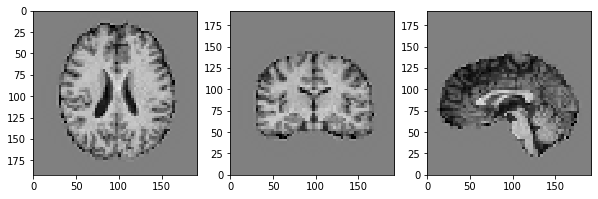

Segmentation


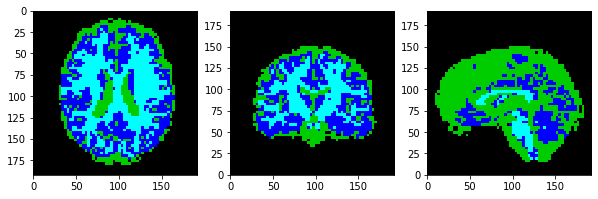

Mask


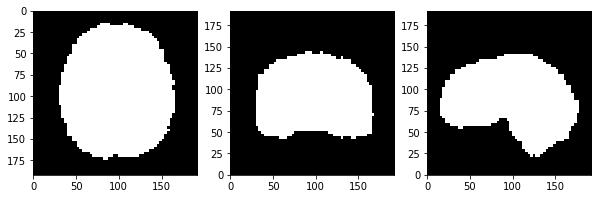

In [ ]:
sample = dataset_train.get_sample(0)

img_name = dataset_train.get_img_name(0)
seg_name = dataset_train.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

### CNN Brain Segmentation Model


In [ ]:
class FCLeNet_Seg(nn.Module):
    def __init__(self, num_classes):
        super(FCLeNet_Seg, self).__init__()
        # Downsampling
        self.conv1 = nn.Conv3d(1, 6, kernel_size=5, bias=True, padding=0)
        self.conv2 = nn.Conv3d(6, 16, kernel_size=5, bias=True, padding=0)
        self.conv3 = nn.Conv3d(16, 64, kernel_size=5, bias=True, padding=0)
        self.conv4 = nn.Conv3d(64, 128, kernel_size=4,
                               stride=2, bias=True, padding=0)
        self.conv5 = nn.Conv3d(128, 84, kernel_size=1, bias=True, padding=0)

        # Upsampling
        self.conv_ups1 = nn.ConvTranspose3d(
            84, 84, kernel_size=5, stride=1, padding=0, bias=False)
        self.conv_ups2 = nn.ConvTranspose3d(
            84, 84, kernel_size=5, stride=2, padding=0, bias=False)
        self.conv_ups3 = nn.ConvTranspose3d(
            84, 84, kernel_size=4, stride=1, padding=0, bias=False)
        self.conv6 = nn.Conv3d(
            84, num_classes, kernel_size=1, bias=True, padding=0)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))

        x = self.conv_ups1(x)
        x = self.conv_ups2(x)
        x = self.conv_ups3(x)

        x = self.conv6(x)

        return x

### TRAINING

In [ ]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 0.655235
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 0.646235


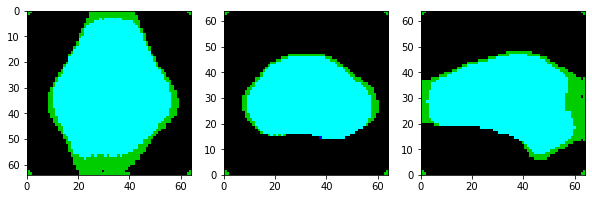

--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 0.497742
+ TRAINING 	Epoch: 3 	Loss: 0.344033
+ TRAINING 	Epoch: 4 	Loss: 0.331558
+ TRAINING 	Epoch: 5 	Loss: 0.325109
+ TRAINING 	Epoch: 6 	Loss: 0.353950
+ TRAINING 	Epoch: 7 	Loss: 0.319111
+ TRAINING 	Epoch: 8 	Loss: 0.272744
+ TRAINING 	Epoch: 9 	Loss: 0.297758
+ TRAINING 	Epoch: 10 	Loss: 0.297522
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 0.296944


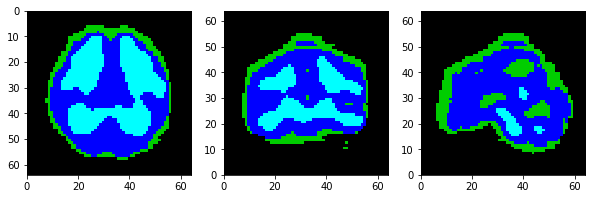

--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 0.254059
+ TRAINING 	Epoch: 12 	Loss: 0.237600
+ TRAINING 	Epoch: 13 	Loss: 0.294406
+ TRAINING 	Epoch: 14 	Loss: 0.216440
+ TRAINING 	Epoch: 15 	Loss: 0.291886
+ TRAINING 	Epoch: 16 	Loss: 0.242499
+ TRAINING 	Epoch: 17 	Loss: 0.254349
+ TRAINING 	Epoch: 18 	Loss: 0.211246
+ TRAINING 	Epoch: 19 	Loss: 0.221601
+ TRAINING 	Epoch: 20 	Loss: 0.220537
--------------------------------------------------
+ VALIDATE 	Epoch: 20 	Loss: 0.214743


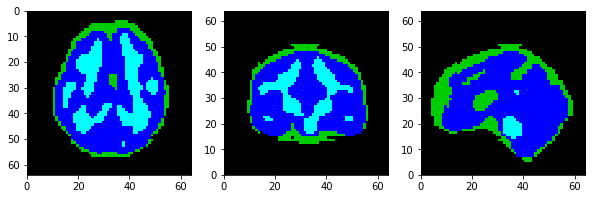

--------------------------------------------------
+ TRAINING 	Epoch: 21 	Loss: 0.238279
+ TRAINING 	Epoch: 22 	Loss: 0.278801
+ TRAINING 	Epoch: 23 	Loss: 0.228495
+ TRAINING 	Epoch: 24 	Loss: 0.195549
+ TRAINING 	Epoch: 25 	Loss: 0.239379
+ TRAINING 	Epoch: 26 	Loss: 0.204220
+ TRAINING 	Epoch: 27 	Loss: 0.195229
+ TRAINING 	Epoch: 28 	Loss: 0.233333
+ TRAINING 	Epoch: 29 	Loss: 0.238077
+ TRAINING 	Epoch: 30 	Loss: 0.202925
--------------------------------------------------
+ VALIDATE 	Epoch: 30 	Loss: 0.207546


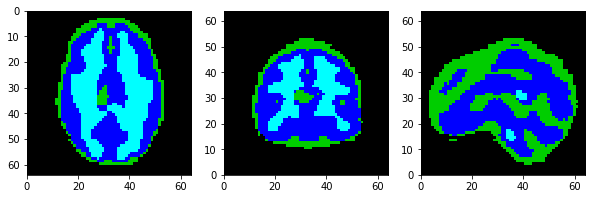

--------------------------------------------------
+ TRAINING 	Epoch: 31 	Loss: 0.216759
+ TRAINING 	Epoch: 32 	Loss: 0.205884
+ TRAINING 	Epoch: 33 	Loss: 0.173205
+ TRAINING 	Epoch: 34 	Loss: 0.202055
+ TRAINING 	Epoch: 35 	Loss: 0.198003
+ TRAINING 	Epoch: 36 	Loss: 0.237121
+ TRAINING 	Epoch: 37 	Loss: 0.205368
+ TRAINING 	Epoch: 38 	Loss: 0.233755
+ TRAINING 	Epoch: 39 	Loss: 0.173056
+ TRAINING 	Epoch: 40 	Loss: 0.196184
--------------------------------------------------
+ VALIDATE 	Epoch: 40 	Loss: 0.202081


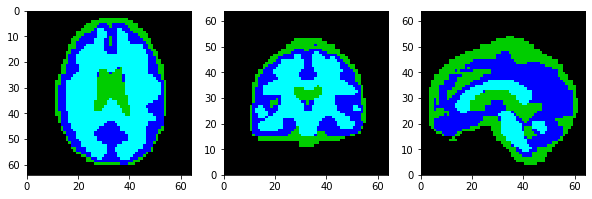

--------------------------------------------------
+ TRAINING 	Epoch: 41 	Loss: 0.209112
+ TRAINING 	Epoch: 42 	Loss: 0.206034
+ TRAINING 	Epoch: 43 	Loss: 0.192884
+ TRAINING 	Epoch: 44 	Loss: 0.178605
+ TRAINING 	Epoch: 45 	Loss: 0.164607
+ TRAINING 	Epoch: 46 	Loss: 0.187320
+ TRAINING 	Epoch: 47 	Loss: 0.144522
+ TRAINING 	Epoch: 48 	Loss: 0.187630
+ TRAINING 	Epoch: 49 	Loss: 0.158097
+ TRAINING 	Epoch: 50 	Loss: 0.179141
--------------------------------------------------
+ VALIDATE 	Epoch: 50 	Loss: 0.174700


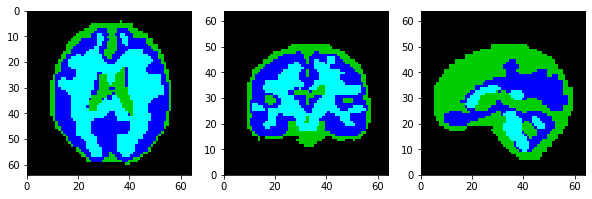

--------------------------------------------------
+ TRAINING 	Epoch: 51 	Loss: 0.171237
+ TRAINING 	Epoch: 52 	Loss: 0.179890
+ TRAINING 	Epoch: 53 	Loss: 0.153396
+ TRAINING 	Epoch: 54 	Loss: 0.154599
+ TRAINING 	Epoch: 55 	Loss: 0.157216
+ TRAINING 	Epoch: 56 	Loss: 0.197078
+ TRAINING 	Epoch: 57 	Loss: 0.171364
+ TRAINING 	Epoch: 58 	Loss: 0.167662
+ TRAINING 	Epoch: 59 	Loss: 0.170072
+ TRAINING 	Epoch: 60 	Loss: 0.179605
--------------------------------------------------
+ VALIDATE 	Epoch: 60 	Loss: 0.173825


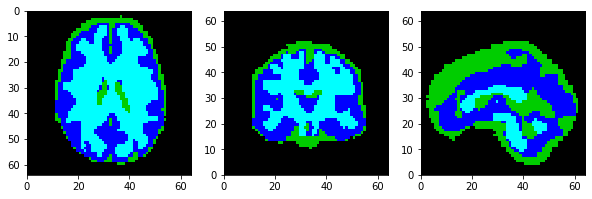

--------------------------------------------------
+ TRAINING 	Epoch: 61 	Loss: 0.161101
+ TRAINING 	Epoch: 62 	Loss: 0.203695
+ TRAINING 	Epoch: 63 	Loss: 0.181380
+ TRAINING 	Epoch: 64 	Loss: 0.172864
+ TRAINING 	Epoch: 65 	Loss: 0.174682
+ TRAINING 	Epoch: 66 	Loss: 0.154507
+ TRAINING 	Epoch: 67 	Loss: 0.216377
+ TRAINING 	Epoch: 68 	Loss: 0.197292
+ TRAINING 	Epoch: 69 	Loss: 0.185837
+ TRAINING 	Epoch: 70 	Loss: 0.172276
--------------------------------------------------
+ VALIDATE 	Epoch: 70 	Loss: 0.170119


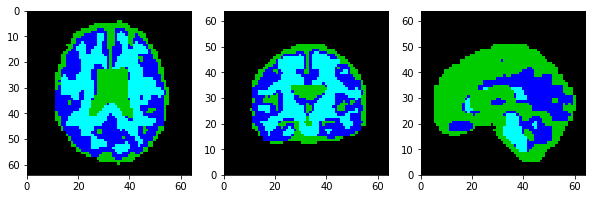

--------------------------------------------------
+ TRAINING 	Epoch: 71 	Loss: 0.158178
+ TRAINING 	Epoch: 72 	Loss: 0.171377
+ TRAINING 	Epoch: 73 	Loss: 0.205315
+ TRAINING 	Epoch: 74 	Loss: 0.145154
+ TRAINING 	Epoch: 75 	Loss: 0.163082
+ TRAINING 	Epoch: 76 	Loss: 0.151144
+ TRAINING 	Epoch: 77 	Loss: 0.173614
+ TRAINING 	Epoch: 78 	Loss: 0.151719
+ TRAINING 	Epoch: 79 	Loss: 0.122597
+ TRAINING 	Epoch: 80 	Loss: 0.146162
--------------------------------------------------
+ VALIDATE 	Epoch: 80 	Loss: 0.142965


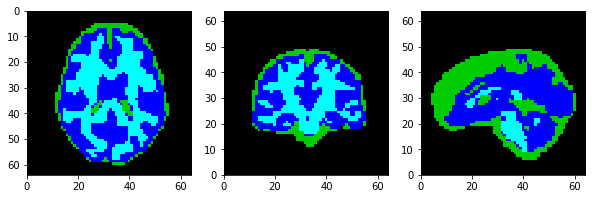

--------------------------------------------------
+ TRAINING 	Epoch: 81 	Loss: 0.148528
+ TRAINING 	Epoch: 82 	Loss: 0.142697
+ TRAINING 	Epoch: 83 	Loss: 0.136445
+ TRAINING 	Epoch: 84 	Loss: 0.151454
+ TRAINING 	Epoch: 85 	Loss: 0.136092
+ TRAINING 	Epoch: 86 	Loss: 0.144058
+ TRAINING 	Epoch: 87 	Loss: 0.124984
+ TRAINING 	Epoch: 88 	Loss: 0.154114
+ TRAINING 	Epoch: 89 	Loss: 0.117828
+ TRAINING 	Epoch: 90 	Loss: 0.176949
--------------------------------------------------
+ VALIDATE 	Epoch: 90 	Loss: 0.175592


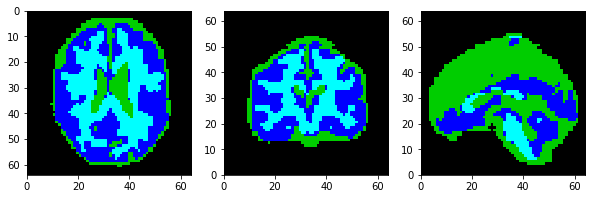

--------------------------------------------------
+ TRAINING 	Epoch: 91 	Loss: 0.130067
+ TRAINING 	Epoch: 92 	Loss: 0.149243
+ TRAINING 	Epoch: 93 	Loss: 0.166804
+ TRAINING 	Epoch: 94 	Loss: 0.153819
+ TRAINING 	Epoch: 95 	Loss: 0.136595
+ TRAINING 	Epoch: 96 	Loss: 0.166085
+ TRAINING 	Epoch: 97 	Loss: 0.135781
+ TRAINING 	Epoch: 98 	Loss: 0.172709
+ TRAINING 	Epoch: 99 	Loss: 0.126564
+ TRAINING 	Epoch: 100 	Loss: 0.147544
--------------------------------------------------
+ VALIDATE 	Epoch: 100 	Loss: 0.148206


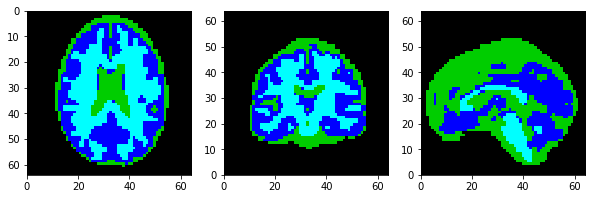

--------------------------------------------------

Finished TRAINING.


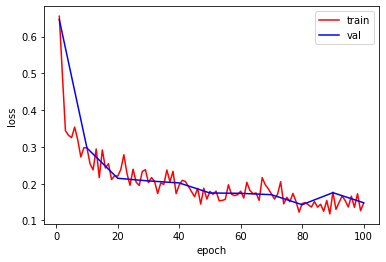

In [ ]:
model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed)  # fix random seed

model = FCLeNet_Seg(num_classes=num_classes).to(device)
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train_log = []
loss_val_log = []
epoch_val_log = []

print('START TRAINING...')
for epoch in range(1, num_epochs + 1):

    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img = batch_samples['img'].to(device)
        seg = batch_samples['seg'].to(device)

        optimizer.zero_grad()
        prd = model(img)

        # [N,4,D*H*W] - 1 FM for each label
        prd_flat = prd.view(prd.size(0), prd.size(1), -1)

        seg_flat = seg.view(seg.size(0), seg.size(1), -1)  # [N,1,D*H*W]
        seg_flat = torch.squeeze(seg_flat, axis=1)
        loss = F.cross_entropy(prd_flat, seg_flat)

        loss.backward()
        optimizer.step()

    loss_train_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        sum_pts = 0
        with torch.no_grad():
            for data_sample in dataloader_val:
                img = batch_samples['img'].to(device)
                seg = batch_samples['seg'].to(device)

                prd = model(img)
                prd_flat = prd.view(prd.size(0), prd.size(1), -1)
                seg_flat = seg.view(seg.size(0), seg.size(1), -1)
                loss_val += F.cross_entropy(prd_flat,
                                            seg_flat.squeeze(1), reduction='sum').item()
                sum_pts += seg_flat.size(2)

        prd = torch.argmax(prd, dim=1)
        prediction = sitk.GetImageFromArray(
            prd.cpu().squeeze().numpy().astype(np.uint8))

        loss_val /= sum_pts

        loss_val_log.append(loss_val)
        epoch_val_log.append(epoch)

        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))
        display_image(sitk.LabelToRGB(prediction, sitk.sitkInt8))
        print('--------------------------------------------------')

torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

print('\nFinished TRAINING.')

plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Loading and pre-processing of testing data



In [ ]:
# Training set of 500
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
ids_seg_train = list(meta_data_reg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' +
                       f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' +
                       f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f +
                       '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

dataset_train = ImageSegmentationDataset(
    files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=1, shuffle=False)


# Test set
meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_reg_test.csv')
ids_seg_test = list(meta_data_reg_test['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' +
                      f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' +
                      f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f +
                      '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(
    files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 100/100 [00:18<00:00,  5.48it/s]


#### Visualise testing example

Just to check how a testing image looks like after pre-processing.

Image: sub-CC321594_T1w_unbiased.nii.gz


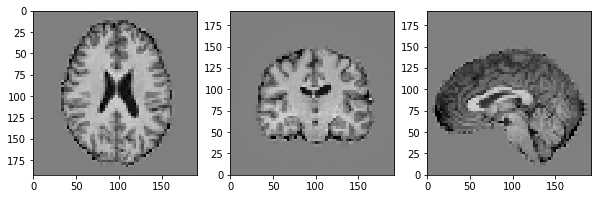

Segmentation


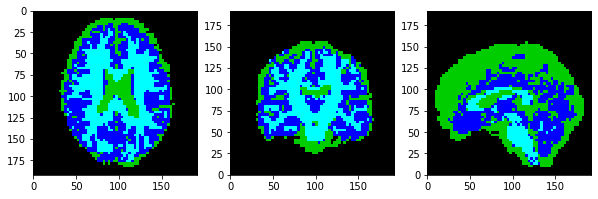

Mask


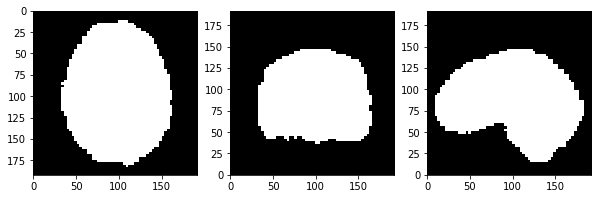

In [ ]:
sample = dataset_test.get_sample(0)
img_name = dataset_test.get_img_name(0)
seg_name = dataset_test.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

### TESTING

Below is an implementation of a full testing procedure that saves the segmentations in an output folder. Feel free to modify this procedure.



In [ ]:
def calculate_dice(pred, label, num_classes=4):
    '''
    pred: tensor of size [N,D,H,W] - image
    label: tensor of size [N,D,H,W] - flattened segmentation label

    returns: dice score size [Num_channels]

    '''
    epsilon = 1e-6
    label = label.squeeze(1)
    labels = F.one_hot(label, num_classes=4)
    labels = labels.permute(0, 4, 1, 2, 3).type(torch.FloatTensor)

    pred = F.one_hot(pred, num_classes=4).permute(
        0, 4, 1, 2, 3).type(torch.FloatTensor)  # [N,C,D,H,W]

    labels = labels.view(labels.size(0), labels.size(1), -1)  # [N,C,D*H*W]
    pred = pred.view(pred.size(0), pred.size(1), -1)

    # Times together and sum to get number of matching elements
    intersection = (labels * pred).sum(-1)
    # intersection shape [N,C]

    denominator = (pred * pred).sum(-1) + (labels * labels).sum(-1)

    dice_per_channel = 2 * \
        (intersection / denominator.clamp(min=epsilon))  # shape [N,C]

    return dice_per_channel

In [ ]:
model_dir = os.path.join(out_dir, 'model')
pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)


def get_segmentations(dataloader, dataset):
    model = FCLeNet_Seg(num_classes=num_classes)
    model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
    model.to(device)
    model.eval()

    print('START TESTING...')

    loss_test = 0
    sum_pts = 0
    idx_test = 0
    dice_test = 0
    dice_scores = []
    with torch.no_grad():
        for data_sample in dataloader:
            img, seg = data_sample['img'].to(
                device), data_sample['seg'].to(device)

            prd = model(img)
            prd_flat = prd.view(prd.size(0), prd.size(1), -1)
            seg_flat = seg.view(seg.size(0), seg.size(1), -1)  # [N,1,D*H*W]
            loss_test += F.cross_entropy(prd_flat,
                                         seg_flat.squeeze(1), reduction='sum').item()
            sum_pts += seg_flat.size(2)

            prd = torch.argmax(prd, dim=1)

            dice_score_per_channel = calculate_dice(prd.cpu(), seg.cpu())
            dice_test += dice_score_per_channel
            dice_scores.append(dice_score_per_channel.numpy())

            sample = dataset.get_sample(idx_test)
            name = dataset.get_seg_name(idx_test)
            prediction = sitk.GetImageFromArray(
                prd.cpu().squeeze().numpy().astype(np.uint8))
            prediction.CopyInformation(sample['seg'])
            sitk.WriteImage(prediction, os.path.join(pred_dir, name))

            idx_test += 1

    loss_test /= sum_pts
    dice_test /= idx_test
    dice_test = dice_test.squeeze()
    print('+ TESTING \tLoss: {:.6f}'.format(loss_test))
    print(
        f'TESTING \tDICE SCORES: \tClass 0 {dice_test[0]} \tClass 1 {dice_test[1]} \tClass 2 {dice_test[2]} \tClass 3 {dice_test[3]} ')
    print(f'AVERAGE DICE SCORE: {torch.mean(dice_test)}')

    # Show last testing sample as an example
    print('\n\nReference segmentation')
    display_image(sitk.LabelToRGB(sample['seg']))
    print('Predicted segmentation')
    display_image(sitk.LabelToRGB(prediction))

    print('\nFinished TESTING.')
    return dice_scores

START TESTING...
+ TESTING 	Loss: 0.155088
TESTING 	DICE SCORES: 	Class 0 0.9893940091133118 	Class 1 0.6937175989151001 	Class 2 0.7629384398460388 	Class 3 0.8023133873939514 
AVERAGE DICE SCORE: 0.8120908737182617


Reference segmentation


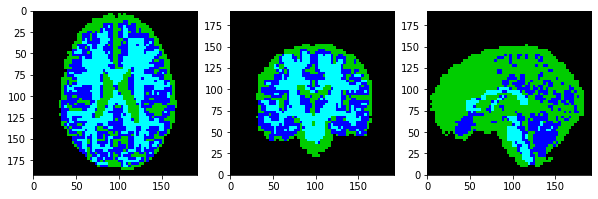

Predicted segmentation


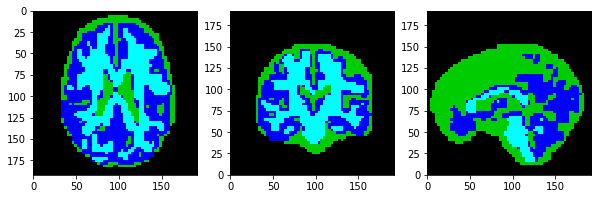


Finished TESTING.
START TESTING...
+ TESTING 	Loss: 0.149780
TESTING 	DICE SCORES: 	Class 0 0.9898269772529602 	Class 1 0.691231369972229 	Class 2 0.7653911113739014 	Class 3 0.8012912273406982 
AVERAGE DICE SCORE: 0.8119351863861084


Reference segmentation


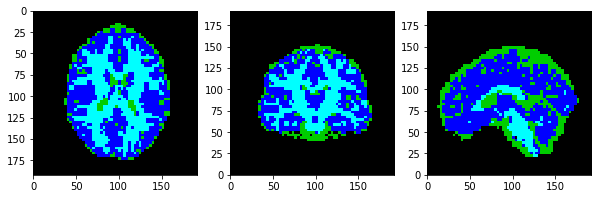

Predicted segmentation


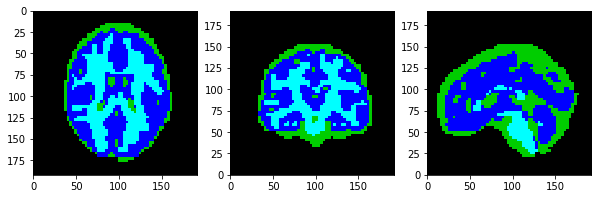


Finished TESTING.


In [ ]:
dice_scores_train = get_segmentations(dataloader_train, dataset_train)
dice_scores_train = np.squeeze(dice_scores_train, 1)

dice_scores_test = get_segmentations(dataloader_test, dataset_test)
dice_scores_test = np.squeeze(dice_scores_test, 1)

#### Box and whisker plots for the different classes

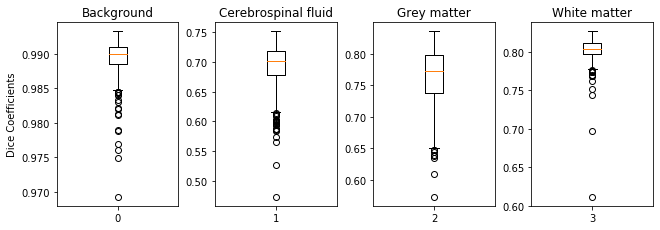

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(9, 3))
for i in range(4):
    axs[i].boxplot(dice_scores_train[:, i], positions=[
                   i])  # ,positions=[0,1,2,3]

    if i == 0:
        axs[i].set_title('Background')
        axs[i].set(ylabel="Dice Coefficients")
    if i == 1:
        axs[i].set_title('Cerebrospinal fluid')
    if i == 2:
        axs[i].set_title('Grey matter')
    if i == 3:
        axs[i].set_title('White matter')


fig.subplots_adjust(left=0.08, right=1, bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)


plt.savefig('boxplots.pdf')
plt.show()

### TASK A-2: Feature calculation

Here we calculate the absolute tissue volumes for each subject, based on the output of the CNN segmentation. The tissue volumes are features, from which we infer the patients' age.

#### Calculating absolute tissue volumes


In [ ]:
import os
import torch

# USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
seg_dir = './output/pred/'


meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
ids_reg_train = list(meta_data_reg_train['subject_id'])
files_reg_seg_train = [seg_dir + 'sub-' + f +
                       '_T1w_seg.nii.gz' for f in ids_reg_train]

meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_reg_test.csv')
ids_reg_test = list(meta_data_reg_test['subject_id'])
files_reg_seg_test = [seg_dir + 'sub-' + f +
                      '_T1w_seg.nii.gz' for f in ids_reg_test]


def calculate_volumes(files_reg_seg):
    # THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
    vols = np.zeros((3, len(files_reg_seg)))

    for idx, _ in enumerate(tqdm(range(len(files_reg_seg)), desc='Calculating Features')):

        seg_filename = files_reg_seg[idx]

        if os.path.exists(seg_filename):
            seg = sitk.ReadImage(seg_filename)

            size = seg.GetSize()
            spacing = seg.GetSpacing()
            seg = sitk.GetArrayFromImage(seg)

            width = (size[0] * spacing[0])/100
            height = (size[1] * spacing[1])/100
            depth = (size[2] * spacing[2])/100

            img_vol = width * height * depth

            seg = torch.tensor(seg).type(torch.int64)  # seg size [1,64,64,64]
            seg = seg.squeeze(1)

            seg = F.one_hot(seg, num_classes=4)  # size [94,116,98]
            seg = seg.permute(3, 0, 1, 2)  # size [4,94,116,98]
            seg_flat = seg.reshape(1, -1)  # size [1,94*116*98]
            seg_flat = seg_flat.numpy()
            proportion_tissue = np.sum(seg_flat)/seg_flat.shape[1]

            brain_vol = img_vol * proportion_tissue

            for i in range(3):
                c = i + 1
                class_img = seg[c, :, :, :]
                class_flat = class_img.reshape(1, -1)
                class_flat = class_flat.numpy()
                vols[i, idx] = (img_vol * np.sum(class_flat) /
                                class_flat.shape[1])
    return vols

Plot features versus age.

In [ ]:
vols_train = calculate_volumes(files_reg_seg_train)
vols_test = calculate_volumes(files_reg_seg_test)

Calculating Features: 100%|██████████| 100/100 [00:04<00:00, 24.52it/s]


Plotting unnormalised features

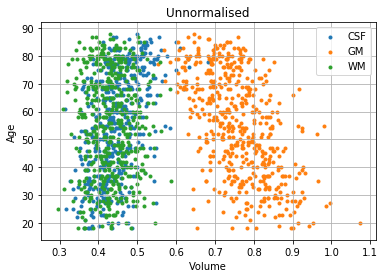

In [ ]:
plt.scatter(vols_train[0, :], meta_data_reg_train['age'], marker='.')
plt.scatter(vols_train[1, :], meta_data_reg_train['age'], marker='.')
plt.scatter(vols_train[2, :], meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Unnormalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF', 'GM', 'WM'))
plt.savefig("unnormalised.pdf")
plt.show()

Plotting normalised tissue volumes. Normalised by total volume

In [ ]:
## CALCULATE RELATIVE TISSUE VOLUMES

vols_normalised_train = np.zeros((3,len(files_reg_seg_train)))
vols_normalised_test = np.zeros((3,len(files_reg_seg_test)))

def normalise(files_reg_seg,vols,vols_normalised):
    for j in range(len(files_reg_seg)):
      total_volume = np.sum(vols[:,j])
      for i in range(3):
        vols_normalised[i,j] = vols[i,j] / total_volume
    return vols_normalised

vols_normalised_train=normalise(files_reg_seg_train,vols_train,vols_normalised_train)
vols_normalised_test = normalise(files_reg_seg_test,vols_test,vols_normalised_test)
print(vols_normalised_test.shape)

(3, 100)


Plot normalised features versus age.

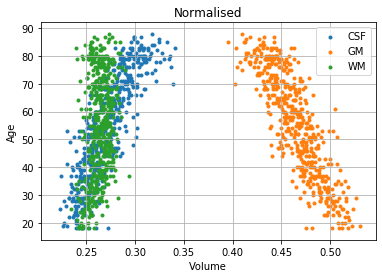

In [ ]:
plt.scatter(vols_normalised_train[0,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised_train[1,:],meta_data_reg_train['age'], marker='.')
plt.scatter(vols_normalised_train[2,:],meta_data_reg_train['age'], marker='.')
plt.grid()
plt.title('Normalised')
plt.xlabel('Volume')
plt.ylabel('Age')
plt.legend(('CSF','GM','WM'))
plt.savefig("normalised.pdf")
plt.show()

Final data for age regression

In [ ]:
X = vols_normalised_train.T
y = meta_data_reg_train['age'].values.reshape(-1,1)

X_test = vols_normalised_test.T
y_test = meta_data_reg_test['age'].values.reshape(-1,1)

print(X.shape)
print(y.shape)

(500, 3)
(500, 1)


### TASK A-3: Age regression and cross-validation

Here we use different regression methods from the scikit-learn toolkit. We evaluate methods using two-fold cross-validation where the dataset of 500 subjects is split into two equally sized sets. 


In [ ]:
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn import ensemble
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.metrics import max_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

y = y.ravel()


# Support vector machines
def SVR_r(X, y, X_test=None, y_test=None, mode='xval'):
    for k in ['linear', 'poly', 'rbf', 'sigmoid']:
        clf_t = SVR(kernel=k)
        reg = make_pipeline(StandardScaler(), clf_t)

    cv = KFold(n_splits=2, random_state=1, shuffle=True)

    if mode == 'xval':
        a = cross_val_score(
            reg, X, y, cv=cv, scoring="neg_mean_absolute_error")

        return a
    elif mode == 'predict':
        reg.fit(X, y)
        # Evaluate model on training/validation data
        predictions = reg.predict(X)
        return predictions
    elif mode == 'test':
        reg.fit(X, y)
        print(len(X_test))
        predictions = reg.predict(X_test)
        print(len(predictions))
        return predictions

        print(a)
        return a


# Passive Agressive Regressor
def PAR(X, y):
    clf = PassiveAggressiveRegressor(max_iter=100, random_state=0)
    reg = make_pipeline(StandardScaler(), clf)
    cv = KFold(n_splits=2, random_state=1, shuffle=True)

    a = cross_val_score(reg, X, y, cv=cv, scoring="neg_mean_absolute_error")

    print(a)
    return a

# Gradient Boosting Regressor 
def gradient_boosting(X, y):
    for lr in [0.001, 0.0005]:
        for max_depth in [1, 2]:
            for n_estimator in [200, 500]:

                params = {'n_estimators': n_estimator, 'max_depth': max_depth, 'min_samples_split': 2,
                          'learning_rate': lr, 'loss': 'ls'}

                clf = ensemble.GradientBoostingRegressor(**params)

                reg = make_pipeline(StandardScaler(), clf)

                cv = KFold(n_splits=2, random_state=1, shuffle=True)
                a = cross_val_score(
                    reg, X, y, cv=cv, scoring="neg_mean_absolute_error")
    print(a)
    return a


# SciKit Learn's MLP
def MLP_r(X, y, X_test=None, y_test=None, mode='xval'):

    hidden_layer_size = (100, 100)
    activation = 'relu'

    learning_rate = 0.001
    solver = 'adam'

    mlp = make_pipeline(StandardScaler(),
                        MLPRegressor(hidden_layer_sizes=hidden_layer_size,
                                     tol=1e-2, max_iter=500, random_state=0,
                                     early_stopping=False,
                                     learning_rate_init=learning_rate,
                                     activation=activation, solver=solver)
                        )

    cv = KFold(n_splits=2, random_state=1, shuffle=True)

    if mode == 'xval':
        a = cross_val_score(
            mlp, X, y, cv=cv, scoring="neg_mean_absolute_error")
        print(a)
        return a
    elif mode == 'predict':
        mlp.fit(X, y)
        # Evaluate model on training/validation data
        predictions = mlp.predict(X)
        return predictions
    elif mode == 'test':
        mlp.fit(X, y)
        print(len(X_test))
        predictions = mlp.predict(X_test)
        print(len(predictions))
        return predictions


svr_loss = SVR_r(X, y)
par_loss = PAR(X, y)
gb_loss = gradient_boosting(X, y)
mlp_loss = MLP_r(X, y, X_test, y_test, mode='xval')

[-9.0758271  -8.10618116]
[-13.18996412 -13.59789668]


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[-7.71208246 -7.27069777]


Plotting regression method results

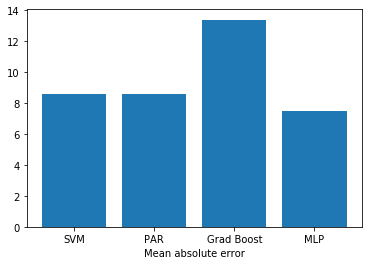

In [ ]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
x = np.arange(4)



svr_loss = -(svr_loss[0] + svr_loss[1])/2
par_loss = -(par_loss[0] + par_loss[1])/2
gb_loss = -(gb_loss[0] + gb_loss[1])/2
mlp_loss = -(mlp_loss[0] + mlp_loss[1])/2

scores = [svr_loss,par_loss,gb_loss,mlp_loss]
fig, ax = plt.subplots()

plt.bar(x, scores)
plt.xticks(x, ('SVM', 'PAR', 'Grad Boost', 'MLP'))
ax.set_xlabel("Mean absolute error")

plt.show()


sklearn's MLP implementation yielded the lowest mean absolute error score.
Making predictions using this method

In [ ]:
predicted_train = MLP_r(X,y,mode='predict')

Error calculation and plotting

mean absolute error: 7.15858595252486
r2 score: 0.7602646495439063


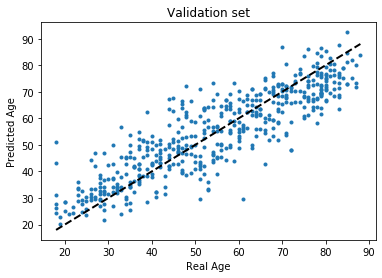

In [ ]:
print('mean absolute error: {0}'.format(mean_absolute_error(y,predicted_train)))
print('r2 score: {0}'.format(r2_score(y,predicted_train)))

fig, ax = plt.subplots()
ax.scatter(y, predicted_train, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
ax.set_title('Validation set')
plt.savefig('real_vs_predict_valid.pdf')
plt.show()

In [ ]:
predicted_test = MLP_r(X,y,X_test,y_test,mode='test')

100
100


mean absolute error: 6.349428876967542
r2 score: 0.8413971693246105


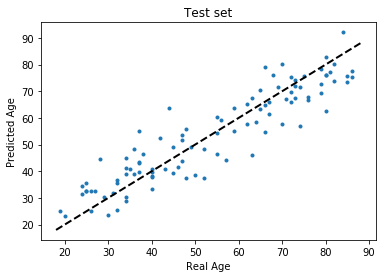

In [ ]:
print('mean absolute error: {0}'.format(mean_absolute_error(y_test,predicted_test)))
print('r2 score: {0}'.format(r2_score(y_test,predicted_test)))

fig, ax = plt.subplots()
ax.scatter(y_test, predicted_test, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
ax.set_title('Test set')
plt.savefig('real_vs_predict_test.pdf')
plt.show()

## Part B: PCA-based regression using grey matter maps

<em>The second approach will make use of grey matter maps that have been already extracted from the MRI scans and aligned to a common reference space to obtain spatially normalised maps. For this, we have used an advanced, state-of-the-art neuroimaging toolkit, called SPM12. The reference space corresponds to the commonly used MNI atlas as seen in the lecture on image segmentation.

Because these grey matter maps are spatially normalised (ie., registered), voxel locations across images from different subjects roughly correspond to the same anatomical locations. This means that each voxel location in the grey matter maps can be treated as an individual feature. Because those maps are quite large at their full resolution there would be a very large number of features to deal with (more than 850,000). A dimensionality reduction may need to be performed before training a suitable regressor on the low-dimensional feature representation. We will use Principal Component Analysis (PCA) to do the dimensionality reduction. It might also be beneficial to apply some pre-processing (downsampling, smoothing, etc.) before running PCA, which should be explored. The implemented pipeline should be evaluated using two-fold cross-validation using the same data splits as in part A for the 500 subjects, so the two different approaches can be directly compared in terms average age prediction accuracy.</em>



### TASK B-1: Pre-processing

<em>fore running PCA to reduce the dimensionality of the feature space for grey matter maps, it might be beneficial to run some pre-processing on the maps. In voxel-based analysis where each voxel location is a feature, it is common to apply some smoothing beforehand. This is to reduce noise and to compensate for errors of the spatial normalisation.

Because the maps are quite large, it might also be worthwile to explore whether downsampling could be performed even before PCA. This would further reduce the dimensionality, and might be even needed in the case where PCA on the orignial resolution runs into memory issues.

Implement a function that performs suitable pre-processing on each grey matter map. </em>



In [ ]:
# import the meta_data
!mkdir ./Pre_proc_data/
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')

print(meta_data_reg_train)

     Unnamed: 0 subject_id  age  gender_code gender_text
0           456   CC520745   63            2      FEMALE
1           431   CC520239   65            2      FEMALE
2           545   CC620592   74            2      FEMALE
3           177   CC310391   41            1        MALE
4           557   CC621011   76            1        MALE
..          ...        ...  ...          ...         ...
495         379   CC510258   60            1        MALE
496         420   CC520127   66            1        MALE
497         488   CC610462   76            2      FEMALE
498          77   CC210657   37            1        MALE
499         499   CC610653   71            1        MALE

[500 rows x 5 columns]


In [ ]:
def apply_pre_proccesing(data):

    # loop through each ID
    for ID in data['subject_id']:
        # read image in
        gm_filename = data_dir + 'greymatter/wc1sub-' + ID + '_T1w.nii.gz'
        img = sitk.ReadImage(gm_filename)

        # apply a gauss filter
        img_gauss = sitk.DiscreteGaussian(img, 1)

        # write image
        sitk.WriteImage(img_gauss, './Pre_proc_data/' +
                        'wc1sub-' + ID + '_T1w.nii.gz')

    return None


def read_in_data(data):

    X = []

    for i, ID in enumerate(data['subject_id']):
        img_gauss_read = sitk.ReadImage(
            './Pre_proc_data/' + 'wc1sub-' + ID + '_T1w.nii.gz')

        # flatten the image
        img_array = sitk.GetArrayFromImage(img_gauss_read).flatten()

        # add to lst
        X.append(img_array)

    X = np.array(X)

    print(X.shape)

    return X

In [ ]:
apply_pre_proccesing(meta_data_reg_train)
img_data = read_in_data(meta_data_reg_train)

(500, 874800)


In [ ]:
X = img_data
y = meta_data_reg_train['age'].values.reshape(-1, 1)

print(X.shape)
print(y.shape)

(500, 874800)
(500, 1)


### TASK B-2: Dimensionality reduction

<em>Implement dimensionality reduction for grey matter maps using [scitkit-learn's PCA](http://scikit-learn.org/stable/modules/decomposition.html#pca). PCA has an option to set the percentage of variance to be preserved (by setting the parameter `n_components` to a value between 0 and 1). The number of principal modes, that is the new dimensionality of the data, is then automatically determined. Try initially to preserve 95% of the variance (`n_components=0.95`). </em>


In [ ]:
from sklearn.decomposition import PCA


def do_pca(X_train, X_test, n_components=0.95):
    # fit to the train and transform both train and test

    pca = PCA(n_components=n_components)

    pca.fit(X_train)

    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

    return X_train, X_test

### TASK B-3: Age regression and cross-validation
Here we use different regression methods from scikit-learn's regression toolkit, and evaluate using two-fold cross validation as with the previous task.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold


# support vector machines
def run_hyper_search_SVM(X_train, y_train):
    pipe = Pipeline([
        ('reduce_dims', PCA(n_components=4)),
        ('clf', SVR(kernel='linear', C=1))])

    param_grid = dict(reduce_dims__n_components=[20, 100, 0.95],
                      clf__C=[20, 100, 0.95],
                      clf__kernel=['linear'])

    grid = GridSearchCV(pipe, param_grid=param_grid, cv=2,
                        scoring="neg_mean_absolute_error", verbose=3)
    grid.fit(X_train, y_train)

    print(grid.best_score_)
    print(grid.best_estimator_)


def run_hyper_search_rand_for(X_train, y_train):
    pipe = Pipeline([
        ('reduce_dims', PCA(n_components=4)),
        ('clf', RandomForestRegressor(n_estimators=100, criterion='mae', max_depth=10))])

    param_grid = dict(reduce_dims__n_components=[100, 0.95],
                      clf__n_estimators=[20, 100, 200],
                      clf__max_depth=[4, 10, 20])

    grid = GridSearchCV(pipe, param_grid=param_grid, cv=2, n_jobs=1,
                        scoring="neg_mean_absolute_error", verbose=3)
    grid.fit(X_train, y_train)

    print(grid.best_score_)
    print(grid.best_estimator_)


def run_evaluation(X, y, model, n_components=0.95):
    clf = make_pipeline(PCA(n_components=n_components), model)

    cv = KFold(n_splits=2, random_state=1, shuffle=True)

    a = cross_val_score(clf, X, y, cv=cv, scoring="neg_mean_absolute_error")

    print(a)
    return a

In [ ]:
# run hyper-search on SVM
run_hyper_search_SVM(X, y.ravel())

In [ ]:
# run the three models and get the cross validation scores for each

model_svr = SVR(kernel="linear", C=1)
model_logreg = LogisticRegression()
model_rdmfor = RandomForestRegressor(
    criterion="mae", max_depth=5, n_estimators=100, ccp_alpha=0)

model_lst = [model_svr, model_logreg, model_rdmfor]


# run the cross validation
for model in model_lst:
    print("Evaluating model: ", model)
    run_evaluation(X, y.ravel(), model, n_components=0.95)

Evaluating model:  SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
[-5.74180556 -5.6301432 ]
Evaluating model:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[-8.368 -7.992]
Evaluating model:  RandomForestRegressor(bootstrap=True, ccp_alpha=0, criterion='mae', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
[-7.86616 -6.97746]


In [ ]:
# train the best model
clf = make_pipeline(PCA(n_components=0.95), model_svr)
clf.fit(X, y.ravel())

print("---- model trained ----")

---- model trained ----


In [ ]:
# import the test set
df_test = pd.read_csv(data_dir + "/meta/meta_data_reg_test.csv")
y_test = df_test["age"]

apply_pre_proccesing(df_test)
X_test = read_in_data(df_test)

# get predictions on the test data
y_pred = clf.predict(X_test)

(100, 874800)


Error calculation and plotting

mean absolute error: 5.421325238287526
r2 score: 0.8906506209643812


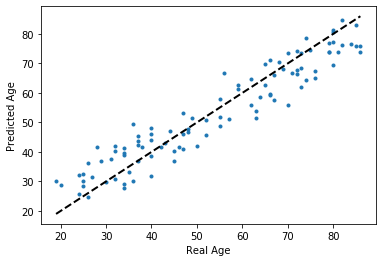

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

print('mean absolute error: {0}'.format(mean_absolute_error(y_test, y_pred)))
print('r2 score: {0}'.format(r2_score(y_test, y_pred)))

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, marker='.')
ax.plot([y_test.min(), y_test.max()], [
        y_test.min(), y_test.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.savefig("./part_b_plot.png")
plt.show()

## Part C: CNN-based regression using grey matter maps

<em>The third approach is similar in nature to the second approach in task B, but instead of using PCA for dimensionality reduction in order to use a more classical regression model, now we will use convolutional neural networks (CNNs) on the grey matter maps for predicting the subject's age directly.

You will need to implement a CNN model that takes a grey matter map as an input and maps it to a one-dimensional, real-valued output. A good starting point may be a LeNet-type architecture and adapt the last layers to convert the classification into a regression network. You should have all the necessary ingredients now from above tasks and the notebooks from the lab tutorials for how to set up a CNN model in PyTorch, how to implement a suitable training and testing routine, and how to run a two-fold cross-validation on the 500 subjects similar to tasks A and B. </em>

.

In [ ]:
# DATA HELPERS FOR REGRESSION


def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if out_size is None:
        out_size = np.round(
            np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
        out_size = np.array(out_size)

    original_direction = np.array(
        image.GetDirection()).reshape(len(original_spacing), -1)
    original_center = (np.array(original_size, dtype=float) -
                       1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / \
        2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(image)


class ImageRegressionDataset(Dataset):
    """Dataset for image regression of grey matter maps."""

    def __init__(self, file_list_grey_mat, file_list_seg, file_list_msk, meta_data_reg, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        self.seg_names = []

        for idx, _ in enumerate(tqdm(range(len(file_list_grey_mat)), desc='Loading Data')):
            grey_mat_path = file_list_grey_mat[idx]
            seg_path = file_list_seg[idx]
            msk_path = file_list_msk[idx]

            # format of path is 'data/brain_age/greymatter/wc1sub-CC520745_T1w.nii.gz'
            # need to extract the ID to find the age
            ID = self.get_ID_from_path(file_list_grey_mat[idx])
            age = meta_data_reg.loc[meta_data_reg['subject_id'] == ID, 'age']
            age = age.item()

            # Extract each scan
            grey_mat = sitk.ReadImage(grey_mat_path, sitk.sitkFloat32)
            seg = sitk.ReadImage(seg_path, sitk.sitkInt64)
            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            # pre=processing
            # img = zero_mean_unit_var(img, msk)
            grey_mat = resample_image(
                grey_mat, img_spacing, img_size, is_label=False)
            seg = resample_image(seg, img_spacing, img_size, is_label=True)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            sample = {'grey_mat': grey_mat, 'seg': seg, 'msk': msk, 'age': age}

            self.samples.append(sample)
            self.img_names.append(os.path.basename(grey_mat_path))
            self.seg_names.append(os.path.basename(seg_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        grey = torch.from_numpy(sitk.GetArrayFromImage(
            sample['grey_mat'])).unsqueeze(0)
        seg = torch.from_numpy(
            sitk.GetArrayFromImage(sample['seg'])).unsqueeze(0)
        msk = torch.from_numpy(
            sitk.GetArrayFromImage(sample['msk'])).unsqueeze(0)
        age = self.samples[item]['age']

        return {'grey_mat': grey, 'seg': seg, 'msk': msk, 'age': age}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

    def get_seg_name(self, item):
        return self.seg_names[item]

    def get_ID_from_path(self, path):
        ID = path[33:41]
        return ID

In [ ]:
# Metadata loading
meta_data_reg = pd.read_csv(data_dir + 'meta/meta_data_reg_train.csv')
ids_reg = list(meta_data_reg['subject_id'])
files_reg_grey_matter = [
    data_dir + 'greymatter/wc1sub-' + f + '_T1w.nii.gz' for f in ids_reg]
files_reg_seg = [data_dir + 'segs_refs/sub-' +
                 f + '_T1w_seg.nii.gz' for f in ids_reg]
files_reg_msk = [data_dir + 'masks/sub-' + f +
                 '_T1w_brain_mask.nii.gz' for f in ids_reg]

In [ ]:
# Parameter definitions

# rnd_seed = 42 #fixed random seed

img_size = [64, 64, 64]
img_spacing = [3, 3, 3]

num_epochs = 100
learning_rate = 0.0001
batch_size = 50  # 50 for training, #100 for testing
val_interval = 10


num_classes = 1

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [ ]:
# MODEL

import torch
import torch.nn as nn
import torch.nn.functional as F

feat_map_const = 5

class CNet(nn.Module):
    def __init__(self):
        super(CNet, self).__init__()

        # Input is [batch_size, 1, 64, 64, 64])
        self.conv1 = nn.Conv3d(1, feat_map_const*2,
                               kernel_size=5, bias=True, padding=0)
        self.conv1_bn = nn.BatchNorm3d(feat_map_const*2)
        self.conv2 = nn.Conv3d(
            feat_map_const*2, feat_map_const*4, kernel_size=5, bias=True, padding=0)
        self.conv2_bn = nn.BatchNorm3d(feat_map_const*4)
        self.conv3 = nn.Conv3d(
            feat_map_const*4, feat_map_const*8, kernel_size=5, bias=True, padding=0)
        self.conv3_bn = nn.BatchNorm3d(feat_map_const*8)
        self.conv4 = nn.Conv3d(
            feat_map_const*8, feat_map_const*8, kernel_size=5, bias=True, padding=0)
        self.conv4_bn = nn.BatchNorm3d(feat_map_const*8)
        self.fc1 = nn.Linear(feat_map_const*8*5*5*5, 1)

    def forward(self, x):
        x = F.max_pool3d(F.relu(self.conv1_bn(self.conv1(x))),
                         kernel_size=2, stride=2, padding=0, ceil_mode=False)
        x = F.max_pool3d(F.relu(self.conv2_bn(self.conv2(x))),
                         kernel_size=2, stride=2, padding=0, ceil_mode=False)
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        return x


########################################

In [ ]:
model = CNet().to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))

Total number of parameters is: 331581


In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

# LOAD VALIDATION DATA AS TRAINING FOR QUICK DEBUGGING
dataset = ImageRegressionDataset(
    files_reg_grey_matter, files_reg_seg, files_reg_msk, meta_data_reg, img_spacing, img_size)

# split the dataset into train and validation dataloaders
num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(0.5 * num_train))

# np.random.seed(42)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler
)

valid_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=valid_sampler
)

Loading Data: 100%|██████████| 500/500 [01:28<00:00,  5.32it/s]


In [ ]:
model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

data_loaders = [valid_loader, train_loader]


# for each dataloader
for n in range(len(data_loaders)):

    # Set each of the loaders
    dataloader_val = data_loaders[n]
    dataloader_train = data_loaders[(n+1) % 2]

    # reinitialise model
    model = FCLeNet().to(device)

    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # reinitialise losses
    loss_train_log = []

    print('START TRAINING...')
    for epoch in range(1, num_epochs + 1):
        for batch_idx, batch_samples in enumerate(dataloader_train):
            sample = batch_samples['grey_mat'].to(device)
            label = batch_samples['age']
            label = label.to(device).reshape([batch_size, 1])

            optimizer.zero_grad()

            # Prediction should be age of subject
            prediction = model(sample)
            # Loss and backprop
            loss = F.l1_loss(prediction, label, reduction='mean')
            loss.backward()
            optimizer.step()

        loss_train_log.append(loss.item())
        print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        loops = 0
        with torch.no_grad():
            for data_sample in dataloader_val:
                loops += 1
                sample = data_sample['grey_mat'].to(device)
                label = data_sample['age']
                label = label.to(device).reshape([batch_size, 1])
                prediction = model(sample)

                loss_val += F.l1_loss(prediction, label, reduction='mean')
        loss_val /= loops
        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val))
        print('--------------------------------------------------')

    torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

    print('\nFinished TRAINING.')

START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 45.698067
+ TRAINING 	Epoch: 2 	Loss: 41.166191
+ TRAINING 	Epoch: 3 	Loss: 33.003960
+ TRAINING 	Epoch: 4 	Loss: 31.164188
+ TRAINING 	Epoch: 5 	Loss: 33.264324
+ TRAINING 	Epoch: 6 	Loss: 24.213404
+ TRAINING 	Epoch: 7 	Loss: 29.866962
+ TRAINING 	Epoch: 8 	Loss: 24.697599
+ TRAINING 	Epoch: 9 	Loss: 24.819593
+ TRAINING 	Epoch: 10 	Loss: 22.896618
+ TRAINING 	Epoch: 11 	Loss: 20.361708
+ TRAINING 	Epoch: 12 	Loss: 20.104713
+ TRAINING 	Epoch: 13 	Loss: 20.457951
+ TRAINING 	Epoch: 14 	Loss: 19.783951
+ TRAINING 	Epoch: 15 	Loss: 14.612201
+ TRAINING 	Epoch: 16 	Loss: 13.808541
+ TRAINING 	Epoch: 17 	Loss: 13.751357
+ TRAINING 	Epoch: 18 	Loss: 11.623998
+ TRAINING 	Epoch: 19 	Loss: 14.732180
+ TRAINING 	Epoch: 20 	Loss: 11.846921
+ TRAINING 	Epoch: 21 	Loss: 8.895570
+ TRAINING 	Epoch: 22 	Loss: 8.437768
+ TRAINING 	Epoch: 23 	Loss: 9.599528
+ TRAINING 	Epoch: 24 	Loss: 7.354317
+ TRAINING 	Epoch: 25 	Loss: 6.516279
+ TRAINING 	Epoch: 26

In [ ]:
# Load test data and make predictions
# Metadata loading
meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_reg_test.csv')
ids_reg = list(meta_data_reg_test['subject_id'])
files_reg_grey_matter = [
    data_dir + 'greymatter/wc1sub-' + f + '_T1w.nii.gz' for f in ids_reg]
files_reg_seg = [data_dir + 'segs_refs/sub-' +
                 f + '_T1w_seg.nii.gz' for f in ids_reg]
files_reg_msk = [data_dir + 'masks/sub-' + f +
                 '_T1w_brain_mask.nii.gz' for f in ids_reg]

In [ ]:
# Make the dataloader
batch_size = 100
dataset_test = ImageRegressionDataset(
    files_reg_grey_matter, files_reg_seg, files_reg_msk, meta_data_reg_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size)

Loading Data: 100%|██████████| 100/100 [00:16<00:00,  5.65it/s]


In [ ]:
# load the model
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))

print(len(dataloader_test))


with torch.no_grad():
    for data_sample in dataloader_test:
        samples = data_sample['grey_mat'].to(device)
        y = data_sample['age']
        print(samples.shape)
        y = y.to(device).view([100, 1])
        predicted = model(samples)

1
torch.Size([100, 1, 64, 64, 64])


Error calculation and plotting

mean absolute error: 5.479420108795166
r2 score: 0.8782735288901907


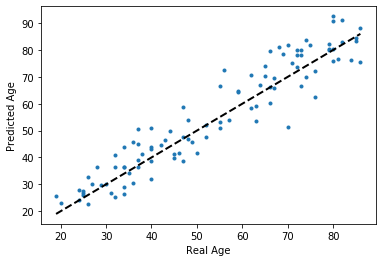

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error

print('mean absolute error: {0}'.format(
    mean_absolute_error(y.cpu(), predicted.cpu())))
print('r2 score: {0}'.format(r2_score(y.cpu(), predicted.cpu())))

fig, ax = plt.subplots()
ax.scatter(y.cpu(), predicted.cpu(), marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.show()

### Discussion

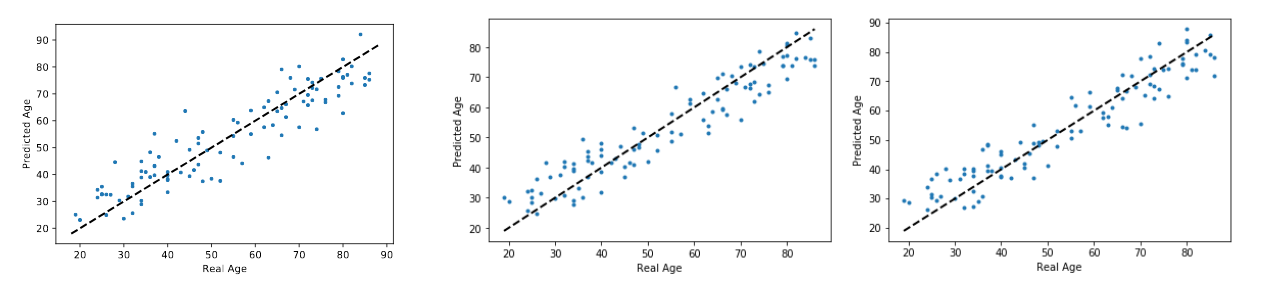

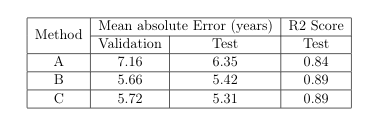

 The results in the table demonstrate that Method A performed worst, B better and C best on the test data. This is to be expected, as the number of processes required to estimate age in A is the highest. Therefore, the error accumulates at each step in the calculation, for example the error in estimating brain matter volumes builds on the error from producing the segmentation. Furthermore, Part A uses only 1 feature to predict the age, whereas Part B uses approximately 500. In comparison it is widely known that CNNs have been able to produce highly representative features to perform the regression task. Since, the performance of the regression model is correlated to the quality of the features, the obtained results appear reasonable. 